# MRI Coding Challenge

## Questions to Stew On

- How much variance is there between the two sessions this subject underwent? Is there any way to make the random forest do anything but angrily say "no"?
- What is simple first-order analysis?
- Am I thresholding properly?
- How do I calculate a BOLD signal from an fMRI time series?
    - An article I found online mentioned using a correlation coefficient. Look into what that is.
- What is out-of-bag error?
    - bagging makes use of multiple overfitting trees to get better results
    - Maybe the error when the model is used on samples that were not part of the training?
    - Get this with RandomForestClassifier.oob_score, which is simply an attribute of any RandomForestClassifier object.
- What is a class conditional posterior estimated random forest?
- Do I need to be using the affine transformation to manipulate this data in some way?

### TODOS

- TODO: Figure out how to determine what threshold to use.
- TODO: figure out what 'first-order analysis' means.
- TODO: figure out how random forest classifiers work.

### STRETCH GOALS

- Make widgets that move through the data interactively
- Turn a slice into a gif moving through the time sequence
- Find a way to make everything 3D

## An Aside that has nothing to do with this project

http://worrydream.com/#!/ScientificCommunicationAsSequentialArt

- I read this paper while taking a break from working on this, and realized that the Vogelstein lab would love it. It's all about ways to make scientific communication more dynamic by embedding interactive visualizations inside the communication medium itself. The content happens to be small-world networks, which is right up your alley. I think stuff like this is great, and that it'd be cool if scientific communication moved in this direction.

- Another aside: I consider my skills to be in their infancy. I started teaching myself Python 3 years ago, but I imported Pandas for the first time 4 months ago, made my first matplotlib graph a month ago, and this project will represent the first machine learning algorithm I've put into practice and the first time I've worked with MRI data.

- The above being said, [I](http://www.codecademy.com/) [have](https://automatetheboringstuff.com) [already](https://www.amazon.com/Introducing-Python-Modern-Computing-Packages/dp/1449359361/ref=sr_1_4?ie=UTF8&qid=1534734843&sr=8-4&keywords=introduction+to+python) [learned](https://www.datacamp.com/) [a](https://jakevdp.github.io/PythonDataScienceHandbook/) [great](https://www.amazon.com/Visual-Display-Quantitative-Information/dp/1930824130) [deal](https://www.amazon.com/Arithmetic-Paul-Lockhart/dp/0674972236/ref=sr_1_1?s=books&ie=UTF8&qid=1534735130&sr=1-1&keywords=arithmetic+paul+lockhart), and [have](https://www.amazon.com/All-Statistics-Statistical-Inference-Springer/dp/0387402721/ref=sr_1_1?s=books&ie=UTF8&qid=1534735017&sr=1-1&keywords=all+of+statistics) [absolutely](https://www.amazon.com/Data-Science-Scratch-Principles-Python/dp/149190142X) [no](https://www.amazon.com/Think-Stats-Allen-B-Downey/dp/1449307116) [plans](https://www.amazon.com/Think-Bayes-Bayesian-Statistics-Python/dp/1449370780/ref=pd_lpo_sbs_14_img_2?_encoding=UTF8&psc=1&refRID=7XDCNW0MK8BQ9J8WEBJ2) [of](https://www.amazon.com/Advice-Young-Investigator-Bradford-Book/dp/0262681501/ref=sr_1_1?s=books&ie=UTF8&qid=1534735238&sr=1-1&keywords=advice+for+a+young+investigator) [stopping](https://www.amazon.com/Mathematics-Rebooted-Fresh-Approach-Understanding-ebook/dp/B07661R8N4) [any](https://www.amazon.com/Envisioning-Information-Edward-R-Tufte/dp/0961392118) [time](https://www.amazon.com/Introduction-Statistical-Learning-Applications-Statistics/dp/1461471370) [soon.](https://web.stanford.edu/~hastie/ElemStatLearn/)

- I want to work with you guys because you (hopefully) share an intellectual and philosophical intensity and engagement that I'd enjoy immensely, and could grow from. My hope is that it's feasible for me to contribute a lot in the long term.

## Get the data

**Goals:**

- Load up both datasets from nifti files
- Load up all necessary libraries.

In [1]:
import pandas as pd  # in case I need it
import numpy as np
import os
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
np.set_printoptions(precision=2, suppress=True)  # For clarity
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # For clarity

In [2]:
mri1 = nib.load('sub-0025865_ses-1_dwi_aligned.nii')
mri2 = nib.load('sub-0025865_ses-2_dwi_aligned.nii')

In [129]:
mri1_data = mri1.get_data()[:, :, :, 1:]  # Turn into numpy data. This appears to be only an axial section.
mri2_data = mri2.get_data()[:, :, :, 1:]

mri1_hc = mri1.get_data()[:, :, :, 0]  # Separate out high contrast image
mri2_hc = mri2.get_data()[:, :, :, 0]

## First impressions of the data

**Goals:**

- Get a sense for what this data looks like.

In [130]:
mri1_data.shape

(182, 218, 182, 30)

182x218

In [131]:
mri1.shape == mri2.shape

True

In [132]:
mri1_data.dtype

dtype('<i2')

In [133]:
hdr = mri1.header

metadata about the image. Looked at this, but don't want to call 'hdr' since it's kind of cluttery.

In [134]:
hdr.get_xyzt_units()
# Time is in seconds, size units are in millimeters.
# So I think this means each of the 30 time images comprise a second, and each scan contains 30 seconds of data,
# and each slice is one more millimeter vertically. This shall be the working hypothesis given no new information.

('mm', 'sec')

In [135]:
mri1.affine  # This relates voxel coordinates to real-world coordinates with a linear transformation.

array([[ -1.,   0.,   0.,  90.],
       [  0.,  -1.,   0.,  91.],
       [  0.,   0.,   1., -72.],
       [  0.,   0.,   0.,   1.]])

**Things I've figured out**:

- An affine array is a linear transformation that lets you move between real-world and voxel coordinates.
- This affine transformation is easy - it simply mirrors the x- and y-axis, and translates by the vector (90, 91, -72). If I wanted, I could use np.linalg.dot to perform the affine transformation.
- Units are in millimeters and seconds.
- Both sessions contain very similar data.

# Problem

## 1. Scale the Data

**Task:**
- Figure out what the distribution of array values looks like.

In [154]:
# Get quick stats info on session 1
pd.Series(mri1_data.ravel()).describe()

count   216630960.00
mean           49.34
std            63.83
min           -30.00
25%             8.00
50%            15.00
75%            85.00
max           600.00
dtype: float64

In [155]:
# Get quick stats info on session 2
pd.Series(mri2_data.ravel()).describe()

count   216630960.00
mean           49.57
std            64.39
min           -36.00
25%             8.00
50%            15.00
75%            84.00
max           590.00
dtype: float64

**Results:**

- Mean of [49, 49] across the whole dataset.
- Min of [-30, -36].
- Max at [600, 590] but with a 75% of [85, 84], so there are some outliers.
- plt.imshow uses the highest value as the thing that defines 'white', so these outliers might lead to some brightness problems in the resulting image.
- mri1_data and mri2_data are extremely similar

**Next Step:**

- Get some histograms to look at what this looks like across z- slices.
- Since the two sets of data are so similar, I'm going to primarily use mri1_data to analyze (I could also average the two datasets if I wanted as well)
- Probably going to want to scale somewhere around vmin=10, vmax=100.

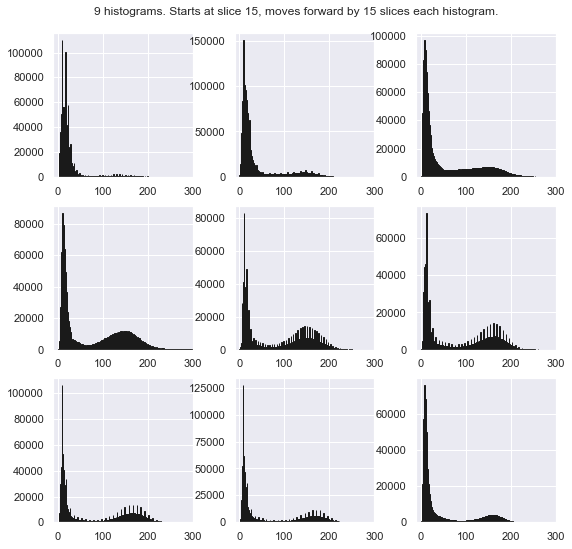

In [149]:
# TODO: scale data
# REMEMBER: first time-point (of the 31 time points) is a high-contrast point prior to testing

fig, ax = plt.subplots(3, 3, figsize=(9,9))

# Loop through every 15 axial slices of the first mri data, starting at slice 15, giving the histogram of
# individual value intensity for each slice.
for i, axi in enumerate(ax.flat):
    axi.hist(mri1_data[:, :, (15*i + 15), :].ravel(), bins=256,
             fc='k', ec='k');
    axi.set_xlim(-10, 300)  # To get all histograms in sync labels-wise

# Title the graph
fig.subplots_adjust(wspace=.3)
plt.suptitle('9 histograms. Starts at slice 15, moves forward by 15 slices each histogram.', y=0.92);

**Results:**


- Most spikes are in the range of [0, 200]
- Any outliers are going to skew the contrast, because the value determining a white pixel is based on the maximum value in a numpy array.
- The spikes around 0 are probably the black space around the edges of slices, which means the actual information is in the range of about [60, 250]

***

**Scaling:**
- Set vmin=60, vmax=250 (based on the histograms) for overall data.

### Plot the Data

- Now that scaling is determined, plot time=5 and z slice=15.

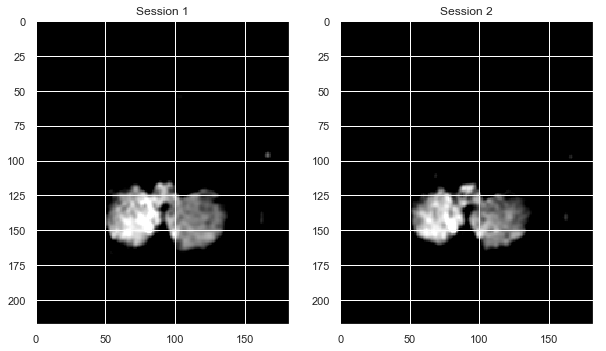

In [162]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 15))
z, t = 15, 5  # time begins with the high-contrast image, so I don't have to worry about 0-indexing.

# Show the data. Rotate 90 degrees because I like that view better.
ax1.imshow(np.rot90(mri1_data[:, :, z, t], k=3), cmap='gray', vmin=60, vmax=200)  # z=15 is where full image begins, z=150 is where full image ends
ax2.imshow(np.rot90(mri2_data[:, :, z, t], k=3), cmap='gray', vmin=60, vmax=200)


# Add title
ax1.set_title('Session 1');
ax2.set_title('Session 2');

## 2. Crop out a brain area, plot that region for each session

**The cerebellum is fun, and easy to see.**

- To do this, I'm going to figure out the coordinates defining the cerebellum, and then cut out a box around it.
- If there's time later, I'm going to look into seeing if I can find some library that lets me crop out the exact coordinates defining the cerebellum, no box involved.

In [181]:
# Make a box around the cerebellum
cerebellum1 = mri1_data[35:145, 90:190, 15:60, :]  # All time slices for specifically the cerebellum.
cerebellum2 = mri2_data[35:145, 90:190, 15:60, :]  # Slices defining the cerebellum determined by experimentation.

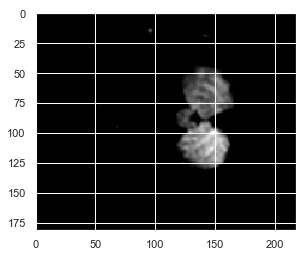

In [163]:
plt.imshow(mri1_data[:, :, 15, 0], cmap='gray', vmin=60, vmax=250)

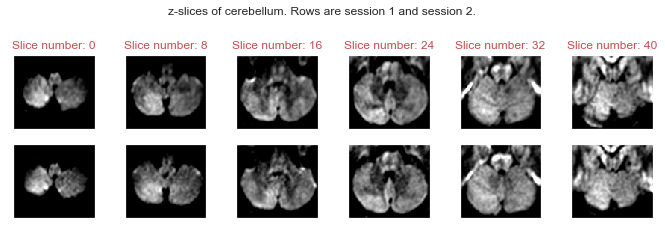

In [164]:
# TODO: figure out how to label the rows

fig, (ax1, ax2) = plt.subplots(2, 6, figsize=(12, 3))

# Plot slices for each session.
t, z, n = 5, 0, 0  # z-slice, time, and axis we're currently on

for i in range(6):  # Not happy with the pythonic-ness of this implementation
    ax1[n].imshow(np.rot90(cerebellum1[:, :, z, t], k=3), cmap='gray', vmin=60, vmax=250)
    ax2[n].imshow(np.rot90(cerebellum2[:, :, z, t], k=3), cmap='gray', vmin=60, vmax=250)
    
    ax1[n].set_xticks([])
    ax2[n].set_xticks([])
    ax1[n].set_yticks([])
    ax2[n].set_yticks([])
    
    ax1[n].set_title('Slice number: {}'.format(z), color='r')
    
    n += 1
    z += 8  # Because there are 5 plots for each session, and 45 z-slices that comprise the cerebellum.

# Add title and adjust.
fig.subplots_adjust(wspace=0)
plt.suptitle('z-slices of cerebellum. Rows are session 1 and session 2.', y=1.1);

## 3. Choose a threshold/intensity value

**Choosing threshold value at slice 15: **

- I should figure out what the distribution of pixel values looks like across all time periods for slice 15 specifically.
- Get the histogram and some summary statistics to look at the distribution of pixel values.

In [151]:
mri1_hc.shape

(182, 218, 182)

In [152]:
# Get quick statistics information for slice 15
sl15 = mri1_data[:, :, 15, :]  # Non-high contrast time points
sl15_2 = mri2_data[:, :, 15, :]
hc = mri1_hc[:, :, 15]  # High contrast slice
hc2 = mri2_hc[:, :, 15]

In [168]:
rv = sl15.ravel()[sl15.ravel() > 60]  # One dimensional data greater than 60
rv2 = sl15_2.ravel()[sl15_2.ravel() > 60]
pd.Series(rv).describe()

count   100796.00
mean       131.83
std         38.43
min         61.00
25%        104.00
50%        132.00
75%        158.00
max        301.00
dtype: float64

- I looked at all data greater than 60, under the assumption that data below 60 is black, non-information bits of the image
- Averaged data 75th percentile is 158

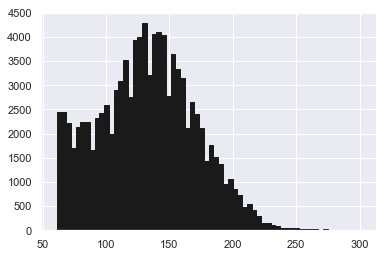

In [166]:
# Look at value distribution.
plt.hist(rv, bins=64, fc='k', ec='k');

- 75th percentile is at 158. Let's see how many outliers there are for each session.
- I will define an outlier as being any value above 158 in the flattened numpy array corresponding to image data at slice 15.

**Number of pixels above 24 at slice 15 for each session:**

In [167]:
a = len(rv[rv > 158])  # For session 1
a

24748

In [169]:
b = len(rv2[rv2 > 158])  # For session 2
b

23610

In [170]:
diff = a - b
diff

1138

In [171]:
diff / a

0.04598351381929853

In [172]:
diff / b

0.0481999152901313

- At slice 15 on the z-axis, the first session has 24748 voxels with value higher than 158.
- At slice 15 on the z-axis, the second session has 23610 voxels with value higher than 158.
- The difference is in the range of 4% of the values

In [198]:
thresh = 158  # This shall be our threshold

## 4. Using threshold, perform first-order analysis

- Note: I didn't know what first-order analysis means, and because I wanted to limit the amount of questions I ask over email (and for the fun of the challenge), I decided not to ask you guys.
- After some googling, I decided that "simple first-order analysis" isn't a special term for a method specific to neuroimaging. I could be wrong, in which case the following analysis will be in an embarassingly incorrect direction.
- After some further etymological investigation, my working hypothesis is that first-order analysis means "analyze the data in whatever way is most interesting, but do it in a linear fashion without getting into multivariate analysis."
- I'm doing this for the cerebellum specifically.
- First up: plot a point in slice 15 over time.

In [183]:
cerebellum1.shape

(110, 100, 45, 30)

In [185]:
# Organize data for plotting
rnd_pxl = cerebellum1[50, 50, 15, :]
time_dict = dict((i, x) for i, x in enumerate(rnd_pxl))  # Being fancy with dictionary comprehensions

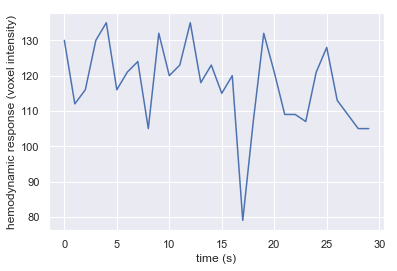

In [186]:
# Lineplot
sns.lineplot(x=list(time_dict.keys()), y=list(time_dict.values()))  # Using seaborn for fun and practice
plt.xlabel('time (s)');
plt.ylabel('hemodynamic response (voxel intensity)');

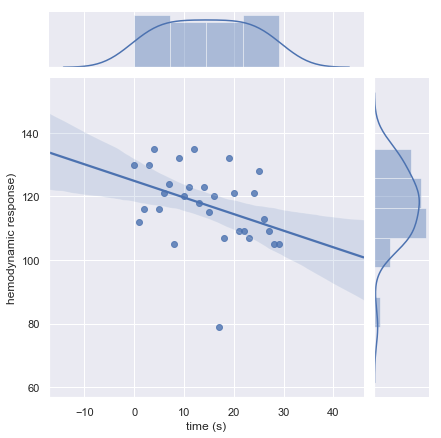

In [187]:
# Jointplot
sns.jointplot(x=list(time_dict.keys()), y=list(time_dict.values()), kind='reg',)  # Using seaborn for fun and practice
plt.xlabel('time (s)');
plt.ylabel('hemodynamic response)');

- Kind of hard to interpret.
- Need better way of analyzing this data holistically
- Let's visualize the whole slice with the threshold

In [197]:
cerebellum1.shape

(110, 100, 45, 30)

In [200]:
mp = cerebellum1.copy()

In [201]:
mp.shape

(110, 100, 45, 30)

In [200]:
mp[mp < thresh] = np.nan  # Make all values less than threshold NaN

ValueError: cannot convert float NaN to integer

## 5. Train a random forest classifier to differentiate between sessions.

In [28]:
from sklearn.ensemble import RandomForestClassifier  # This should be the one
# Read through source code here
# invidual trees available in estimators_
# export_graphvis: for visualizing trees

**How to do this?**

- The two datasets need to be concatanated in some way (another dimension?) into a single fat array.
    - Need to think through how I want to organize this data.
- Make a target array consisting of 0s and 1s which will classify the points as belonging to one dataset or another.

### Out-of-bag error

In [29]:
# TODO: figure out how random forest classifiers work.
# TODO: learn what out-of-bag error means.
# TODO: learn what a class conditional posterior estimated random forest is.

### Distribution of class conditional posteriors estimated random forest

# Ending Thoughts

- So, this analysis is actually a decent showcase of the skills I'd have to offer
- My stats background isn't great (but it is improving quickly). That was painfully obvious to me while I was going through the analysis (although it was super fun to do).
- My python background is certainly way above average for a newly-graduated neuroscience major. I have plans to focus hard on ``sci-kit learn`` and visualization over the course of the next month or two. I didn't have the chance to show my ability to play with data in ``Pandas``, since images don't lend themselves too well to that, but that's currently my strong suit. I also know how to work with the ``os`` module pretty well.
- Above all, I'm motivated and I love this stuff.